In [1]:
import pandas as pd

In [2]:
candidates = pd.read_csv('./dressipi_recsys2022/candidate_items.csv')
candidates

,item_id
0,4
1,8
2,9
3,19
4,20
...,...
4985,28128
4986,28131
4987,28132
4988,28133


In [3]:
items = pd.read_csv('./dressipi_recsys2022/item_features.csv')
items

,item_id,feature_category_id,feature_value_id
0,2,56,365
1,2,62,801
2,2,68,351
3,2,33,802
4,2,72,75
...,...,...,...
471746,28143,68,351
471747,28143,55,390
471748,28143,11,109
471749,28143,73,91


In [4]:
from datetime import datetime


def dateparse(date):    
    return int(datetime.strptime(date.split('.')[0], '%Y-%m-%d  %H:%M:%S').timestamp())

train_purchases = pd.read_csv('./dressipi_recsys2022/train_purchases.csv', parse_dates=[2])

# train_purchases['ts'] = train_purchases['date'].astype('int64')
train_purchases

,session_id,item_id,date
0,3,15085,2020-12-18 21:26:47.986
1,13,18626,2020-03-13 19:36:15.507
2,18,24911,2020-08-26 19:20:32.049
3,19,12534,2020-11-02 17:16:45.920
4,24,13226,2020-02-26 18:27:44.114
...,...,...,...
999995,4439986,2915,2021-05-13 11:56:37.464
999996,4439990,8786,2020-08-22 14:28:22.382
999997,4439994,21630,2020-11-27 20:10:28.961
999998,4439999,16962,2020-11-27 11:01:41.356


In [5]:
train_sessions = pd.read_csv('./dressipi_recsys2022/train_sessions.csv', parse_dates=[2])
train_sessions

,session_id,item_id,date
0,3,9655,2020-12-18 21:25:00.373
1,3,9655,2020-12-18 21:19:48.093
2,13,15654,2020-03-13 19:35:27.136
3,18,18316,2020-08-26 19:18:30.833
4,18,2507,2020-08-26 19:16:31.211
...,...,...,...
4743815,4440001,20409,2020-10-30 23:37:20.658
4743816,4440001,14155,2020-10-30 23:31:56.607
4743817,4440001,14303,2020-10-30 23:36:17.934
4743818,4440001,27852,2020-10-30 23:39:55.186


In [6]:
test_leaderboard_sessions = pd.read_csv('./dressipi_recsys2022/test_leaderboard_sessions.csv')
test_leaderboard_sessions

,session_id,item_id,date
0,26,19185,2021-06-16 09:53:54.158
1,200,17089,2021-06-25 12:23:40.811
2,200,17089,2021-06-25 12:24:36.631
3,200,8060,2021-06-25 12:24:41.677
4,200,4758,2021-06-25 12:24:50.692
...,...,...,...
229349,4439653,25955,2021-06-11 10:22:57.47
229350,4439653,12179,2021-06-11 10:23:00.663
229351,4439757,2078,2021-06-30 11:42:15.073
229352,4439757,2078,2021-06-30 11:43:13.725


# Embedding items
Items are represented in a sparse format with the id of the feature and its value. We have no information on whether or not it is categorical or numerical, or the number of features. We want to explore them a little bit and find a compact representation.

First we want to know the coverage of each feature. Do a plot with, in x-axis, the feature id, and in y-axis, the number of non-null values.

Text(0.5, 0, 'feature_category_id')

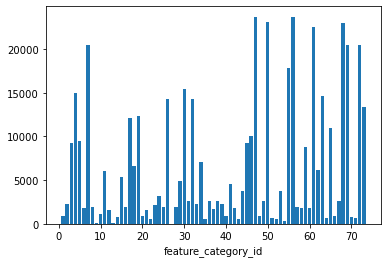

In [7]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (15,7)
df = items.groupby('feature_category_id').count().reset_index()
plt.bar(df.feature_category_id, df.item_id)
plt.xlabel('feature_category_id')

73 features is not that much, let's see how each of them look. Display the counts / min / max / std for each feature. You should see that one feature is useless, remove it!

In [8]:
df = items.groupby('feature_category_id').agg({'item_id': ['describe']})
df.columns = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
df = df.reset_index()
df = df.sort_values(by=['count'])

In [9]:
df = df.drop([26])
df

,feature_category_id,count,mean,std,min,25%,50%,75%,max
8,9,137.0,13674.226277,7833.222381,277.0,6671.00,14012.0,20751.00,27387.0
12,13,137.0,13674.226277,7833.222381,277.0,6671.00,14012.0,20751.00,27387.0
53,54,341.0,13518.428152,8378.722585,27.0,6604.00,13602.0,20621.00,28117.0
51,52,568.0,14250.339789,8148.872034,25.0,6852.00,14440.0,21343.00,28123.0
42,43,569.0,14239.544815,8145.766580,25.0,6870.00,14430.0,21331.00,28123.0
...,...,...,...,...,...,...,...,...,...
60,61,22512.0,14076.389481,8100.751727,2.0,7090.75,14095.5,21057.25,28143.0
67,68,23038.0,14072.108907,8101.374615,2.0,7079.25,14085.0,21058.75,28143.0
49,50,23077.0,14075.044547,8102.635961,2.0,7079.00,14092.0,21062.00,28143.0
46,47,23691.0,14053.882107,8103.749598,2.0,7054.50,14061.0,21047.50,28143.0


If 73 features is not a lot, it is still a big number given the number of samples for your poor laptop if you make it dense. It is also good practice to preprocess the data into a set of embeddings without sparse format because most ML algorithm do not handle sparse. We want to do it now. Use TruncatedSVD from scikit-learn with n_components = 12 (or less depending on your memory) and compute embeddings for your items.

In [10]:
from pandas.api.types import CategoricalDtype
from scipy.sparse import csr_matrix, coo_matrix
from sklearn.decomposition import TruncatedSVD
import numpy as np

item_cat = CategoricalDtype(categories=sorted(range(items.item_id.unique().max() + 1)), ordered=True)
feature_cat = CategoricalDtype(categories=sorted(items.feature_category_id.unique()), ordered=True)
item_index = items.item_id.astype(item_cat).cat.codes
feature_index = items.feature_category_id.astype(feature_cat).cat.codes

X = coo_matrix((items.feature_value_id, (item_index, feature_index)), shape=(28144, 73))
X

<28144x73 sparse matrix of type '<class 'numpy.int64'>'
	with 471751 stored elements in COOrdinate format>

In [11]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=12, random_state=42)
X_truncated = svd.fit_transform(X)
df = pd.DataFrame(X_truncated)
df.shape

(28144, 12)

You now have a matrix of dimension (28144, n_components) representing the items.

In [12]:
df

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,794.680184,377.343645,-303.561667,669.612878,487.114816,31.150264,179.057078,297.354225,-152.977069,-448.542619,-81.610898,46.551205
3,2387.218101,-924.921010,161.342829,-448.550071,-36.610126,-508.695889,-261.150256,140.757636,-136.541817,-86.523773,103.279438,-517.190904
4,2304.639154,-837.402436,194.342672,-143.934268,-183.789390,3.303109,190.619304,-170.592365,-157.106468,-63.470876,-371.549779,54.107111
...,...,...,...,...,...,...,...,...,...,...,...,...
28139,2496.719059,-681.709966,127.865501,94.363956,-141.323393,830.504472,-244.857063,-96.601762,367.063095,38.615850,-406.815205,-29.913621
28140,747.063373,532.023460,-1458.557350,-589.887960,-396.119736,6.411890,44.176747,-82.473067,-223.206356,-183.559911,79.866258,-78.188882
28141,2039.201872,-664.322600,27.056805,-712.698201,16.570404,17.018284,252.190019,-164.911473,-58.054439,-298.787993,-75.164771,-140.081615
28142,1472.569195,356.499021,-347.940105,38.524886,879.686008,493.892279,56.306616,11.915160,227.284378,-35.908917,-238.773668,-303.867624


# Embedding sessions

Sessions are defined by a series of items, we first want to see what they look like to be able to find a suitable representation for them.

My advice: start by sampling the train_sessions dataframe to keep 5% or 10% otherwise your memory may suffer.

Then plot the distribution of session sizes: x-axis is the size of the session, y-axis is the number of sessions of this size. Determine a threshold to contain completely 90% of the sessions. This is how we will compute the session representation.

In [13]:
sample = train_sessions.sample(frac=1, random_state=42)
sample

,session_id,item_id,date
1177821,1102367,13043,2020-04-15 01:58:28.674
3969416,3712749,6735,2020-10-30 13:05:04.617
24877,23678,18786,2021-05-29 14:07:39.570
2975055,2780725,20599,2021-03-21 16:31:15.721
3654824,3416917,20808,2020-06-09 08:13:40.117
...,...,...,...
1136074,1063731,15777,2021-05-13 12:24:38.016
1570006,1469240,14907,2020-05-02 18:33:58.395
2234489,2089296,19908,2020-11-29 15:13:58.259
4304572,4028698,23241,2020-11-21 07:08:57.022


i: 10
percent: 0.91%


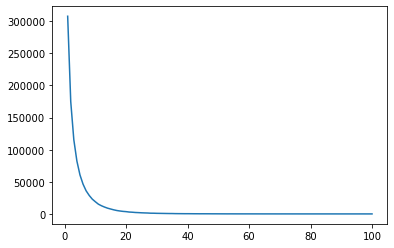

In [14]:
tmp = sample.groupby('session_id').count().reset_index()
tmp = tmp.groupby('item_id').count().reset_index()

r = 0
for i in range(tmp.shape[0]):
    r += tmp.session_id[i]
    if r / tmp.session_id.sum() >= 0.9:
        ri = i
        print(f'i: {i}')
        print(f'percent: {round(r / tmp.session_id.sum(), 2)}%')
        break

plt.plot(tmp.item_id, tmp.session_id)

Let $k$ be the length you have picked for your session. Create a vectorize representation of your sessions by either concatenating the embedding of the corresponding items, or averaging them (if memory is scarse).

In [15]:
df['item_id'] = df.index
sample = sample.merge(df, on='item_id', how='left').groupby('session_id').median().reset_index().drop('item_id', axis=1)
sample

,session_id,0,1,2,3,4,5,6,7,8,9,10,11
0,3,785.516809,562.549825,-1516.871373,-581.048849,-424.922564,151.049881,38.515058,-58.148928,-208.468048,-241.769119,144.517986,-87.033619
1,13,1877.564964,290.626847,-639.722764,1337.928538,194.422779,-363.871228,-88.646277,-529.044868,-13.508655,689.032136,-90.140210,-88.064068
2,18,2446.074060,-691.736147,35.098251,-347.365311,109.431896,-40.345950,340.363085,-354.613533,-256.811138,244.504638,-425.189466,212.202529
3,19,2388.890990,-766.554122,149.043615,-40.218604,-228.888942,507.174819,3.672196,-167.636193,-121.642895,17.446739,152.853897,-143.543796
4,24,1618.909513,698.413946,-265.473567,262.308666,129.806506,95.627765,-174.224300,101.649120,62.097265,14.261108,105.267423,96.382954
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,4439986,1480.111954,173.983883,-473.861636,1198.259710,62.237170,-195.048527,267.357650,-26.271739,135.338922,-591.439842,200.616635,237.009272
999996,4439990,2266.948024,-643.248194,15.040665,45.603591,-286.998021,490.701421,26.443206,-72.659208,80.556581,-45.206547,185.099088,49.407948
999997,4439994,1951.515892,-702.964400,118.461848,194.705711,-439.570914,466.794238,1.319837,-100.610772,-103.240504,70.739670,37.442039,-201.521127
999998,4439999,2199.512144,-718.044519,28.784043,-341.773655,-288.897843,-314.102390,966.894299,-33.319996,-105.795188,52.949765,51.932424,-104.298986


# Embedding purchases
Purchases are one item, so we simply use their embedding. However, we also need to add negative samples so that our model not only learn on positives (One class SVM can do this, but those models are not known to generalize well...). In order to generate negative samples, shuffle the item_id columns of 4 copies of the purchase array. The original values have a label 1, the copies that have been shuffled have a value of 0.

In [16]:
import random

n = 4
random_states = random.sample(range(1, 100), n + 1)

tmp0 = train_purchases.copy().merge(df, on='item_id', how='left')
tmp1 = tmp0.copy()
tmp0['label'] = 0
tmp1['label'] = 1
tmp1 = tmp1.sample(frac=1, random_state=random_states[-1]).reset_index(drop=True)
random_states.pop()
all_purchases = [tmp1]

for i, rs in zip(range(n), random_states):
    tmp = tmp0.copy()
    tmp = tmp.sample(frac=1, random_state=rs).reset_index(drop=True)
    all_purchases.append(tmp)

all_purchases = pd.concat(all_purchases).reset_index(drop=True)
all_purchases

,session_id,item_id,date,0,1,2,3,4,5,6,7,8,9,10,11,label
0,1710972,18415,2021-02-15 02:17:36.560,2490.986954,-705.218292,-70.415047,-89.912912,-74.058738,-73.894182,-194.742223,-117.093073,-149.641721,-296.001910,-418.328039,112.226877,1
1,1923748,21092,2020-05-06 16:03:46.977,941.833332,814.073521,-1731.701814,-724.901070,-189.611340,70.805056,-44.132103,119.834957,255.345549,137.826747,-203.078524,-88.234855,1
2,1582724,12796,2020-08-01 11:15:29.278,2299.177126,-826.836270,310.353701,-185.101801,-161.096417,779.156941,-123.699992,-250.089993,-74.966963,121.805007,380.835107,-108.252166,1
3,1122747,21965,2021-04-09 06:56:26.385,2369.265906,-800.202746,193.949145,2.633964,-247.236126,712.763861,-75.378066,-161.075370,66.090954,-283.455414,-84.964718,-220.809110,1
4,2570540,21182,2020-08-02 20:44:53.365,1856.819475,-94.994293,-328.955719,1063.091924,-327.579417,360.402733,-110.225988,740.132865,-109.184523,215.138612,-273.458089,41.098330,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999995,3134952,12586,2020-12-11 12:55:59.419,2236.633010,-790.703176,165.784538,53.624986,-309.860936,670.210165,-175.719473,-261.864116,-97.772528,-211.370120,-260.811244,-127.370017,0
4999996,445221,23088,2020-04-11 15:24:58.012,1991.429385,1415.956280,180.418724,951.358945,-374.655814,-205.072670,57.280943,115.931877,393.463306,-362.601224,102.092586,237.117353,0
4999997,830934,8144,2020-02-09 23:07:54.816,1217.384076,140.485400,-75.024783,-435.861439,1113.215228,-118.783095,-107.085858,-27.884007,-27.416340,-170.206958,88.239295,-256.657313,0
4999998,29038,25270,2020-12-14 14:57:35.169,1380.137572,115.180064,-398.264092,1160.197219,1.280541,-219.502876,231.318453,-38.599866,62.790200,-470.340113,214.180418,149.104291,0


# Merge everything

We merge the whole dataset together to fit a model. For each session we concatenate:
* The history of the user
* The purchase embedding, with the label

We will have our training set!

In [17]:
finalDF = sample.merge(all_purchases, on='session_id', how='inner').drop(['session_id', 'item_id', 'date'], axis=1)

In [18]:
finalDF

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,3_y,4_y,5_y,6_y,7_y,8_y,9_y,10_y,11_y,label
0,785.516809,562.549825,-1516.871373,-581.048849,-424.922564,151.049881,38.515058,-58.148928,-208.468048,-241.769119,...,-590.228413,-461.644599,142.298055,11.534155,-86.081309,-204.335172,-150.050144,163.988061,-138.480498,1
1,785.516809,562.549825,-1516.871373,-581.048849,-424.922564,151.049881,38.515058,-58.148928,-208.468048,-241.769119,...,-590.228413,-461.644599,142.298055,11.534155,-86.081309,-204.335172,-150.050144,163.988061,-138.480498,0
2,785.516809,562.549825,-1516.871373,-581.048849,-424.922564,151.049881,38.515058,-58.148928,-208.468048,-241.769119,...,-590.228413,-461.644599,142.298055,11.534155,-86.081309,-204.335172,-150.050144,163.988061,-138.480498,0
3,785.516809,562.549825,-1516.871373,-581.048849,-424.922564,151.049881,38.515058,-58.148928,-208.468048,-241.769119,...,-590.228413,-461.644599,142.298055,11.534155,-86.081309,-204.335172,-150.050144,163.988061,-138.480498,0
4,785.516809,562.549825,-1516.871373,-581.048849,-424.922564,151.049881,38.515058,-58.148928,-208.468048,-241.769119,...,-590.228413,-461.644599,142.298055,11.534155,-86.081309,-204.335172,-150.050144,163.988061,-138.480498,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999995,1517.230715,137.504800,-417.864125,1122.216029,6.896573,-214.237945,234.637515,-80.868245,84.674446,-442.771369,...,-841.333697,-498.138916,49.068680,-14.756826,55.594205,163.774960,0.922579,-189.645059,24.961372,1
4999996,1517.230715,137.504800,-417.864125,1122.216029,6.896573,-214.237945,234.637515,-80.868245,84.674446,-442.771369,...,-841.333697,-498.138916,49.068680,-14.756826,55.594205,163.774960,0.922579,-189.645059,24.961372,0
4999997,1517.230715,137.504800,-417.864125,1122.216029,6.896573,-214.237945,234.637515,-80.868245,84.674446,-442.771369,...,-841.333697,-498.138916,49.068680,-14.756826,55.594205,163.774960,0.922579,-189.645059,24.961372,0
4999998,1517.230715,137.504800,-417.864125,1122.216029,6.896573,-214.237945,234.637515,-80.868245,84.674446,-442.771369,...,-841.333697,-498.138916,49.068680,-14.756826,55.594205,163.774960,0.922579,-189.645059,24.961372,0


# Learn a model and predict on test

This is it. You have now a dataset that you can directly pass to a LogisticRegression. For the testing part, perform your prediction on all candidates and pick the hundred ones that have the highest results.

<AxesSubplot:>

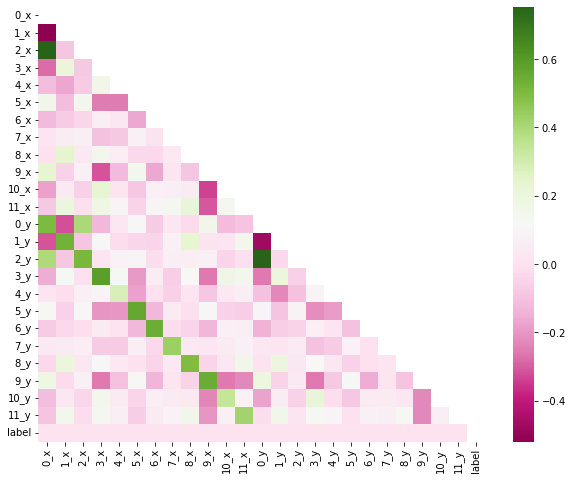

In [19]:
import seaborn as sns

plt.figure(figsize=(10,8))
corr = finalDF.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap="PiYG", mask=mask)

In [20]:
from sklearn.model_selection import train_test_split

X = finalDF.drop(['label'], axis=1)
y = finalDF['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error

lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f'mse: {round(mse, 3)}')
print(f'score: {round(lr.score(X_test, y_test), 3)}')
confusion_matrix(y_test, y_pred)


mse: 0.2
score: 0.8


array([[800036,      0],
       [199964,      0]])

##  Evaluate the model

In [22]:
# Create a dataframe with all item_id and features
df_item_features = df.copy()

sessions = train_sessions.sample(frac=1, random_state=42)
sessions = sessions.merge(df, on='item_id', how='left').groupby('session_id').median().reset_index().drop('item_id', axis=1)

len_items = df_item_features.shape[0]
row = sessions.iloc[0].to_numpy()

list = np.array([row for i in range(len_items)])

df_test = pd.DataFrame(list, columns=sessions.loc[0].index)
df_test['item_id'] = df_test.index
df_test

,session_id,0,1,2,3,4,5,6,7,8,9,10,11,item_id
0,3.0,785.516809,562.549825,-1516.871373,-581.048849,-424.922564,151.049881,38.515058,-58.148928,-208.468048,-241.769119,144.517986,-87.033619,0
1,3.0,785.516809,562.549825,-1516.871373,-581.048849,-424.922564,151.049881,38.515058,-58.148928,-208.468048,-241.769119,144.517986,-87.033619,1
2,3.0,785.516809,562.549825,-1516.871373,-581.048849,-424.922564,151.049881,38.515058,-58.148928,-208.468048,-241.769119,144.517986,-87.033619,2
3,3.0,785.516809,562.549825,-1516.871373,-581.048849,-424.922564,151.049881,38.515058,-58.148928,-208.468048,-241.769119,144.517986,-87.033619,3
4,3.0,785.516809,562.549825,-1516.871373,-581.048849,-424.922564,151.049881,38.515058,-58.148928,-208.468048,-241.769119,144.517986,-87.033619,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28139,3.0,785.516809,562.549825,-1516.871373,-581.048849,-424.922564,151.049881,38.515058,-58.148928,-208.468048,-241.769119,144.517986,-87.033619,28139
28140,3.0,785.516809,562.549825,-1516.871373,-581.048849,-424.922564,151.049881,38.515058,-58.148928,-208.468048,-241.769119,144.517986,-87.033619,28140
28141,3.0,785.516809,562.549825,-1516.871373,-581.048849,-424.922564,151.049881,38.515058,-58.148928,-208.468048,-241.769119,144.517986,-87.033619,28141
28142,3.0,785.516809,562.549825,-1516.871373,-581.048849,-424.922564,151.049881,38.515058,-58.148928,-208.468048,-241.769119,144.517986,-87.033619,28142


In [23]:
# Merge df_test with df_item_features
df_test = df_test.merge(df_item_features, on="item_id", how="left")

In [24]:
df_test.drop(columns=["item_id", "session_id"], inplace=True)
df_test

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,2_y,3_y,4_y,5_y,6_y,7_y,8_y,9_y,10_y,11_y
0,785.516809,562.549825,-1516.871373,-581.048849,-424.922564,151.049881,38.515058,-58.148928,-208.468048,-241.769119,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,785.516809,562.549825,-1516.871373,-581.048849,-424.922564,151.049881,38.515058,-58.148928,-208.468048,-241.769119,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,785.516809,562.549825,-1516.871373,-581.048849,-424.922564,151.049881,38.515058,-58.148928,-208.468048,-241.769119,...,-303.561667,669.612878,487.114816,31.150264,179.057078,297.354225,-152.977069,-448.542619,-81.610898,46.551205
3,785.516809,562.549825,-1516.871373,-581.048849,-424.922564,151.049881,38.515058,-58.148928,-208.468048,-241.769119,...,161.342829,-448.550071,-36.610126,-508.695889,-261.150256,140.757636,-136.541817,-86.523773,103.279438,-517.190904
4,785.516809,562.549825,-1516.871373,-581.048849,-424.922564,151.049881,38.515058,-58.148928,-208.468048,-241.769119,...,194.342672,-143.934268,-183.789390,3.303109,190.619304,-170.592365,-157.106468,-63.470876,-371.549779,54.107111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28139,785.516809,562.549825,-1516.871373,-581.048849,-424.922564,151.049881,38.515058,-58.148928,-208.468048,-241.769119,...,127.865501,94.363956,-141.323393,830.504472,-244.857063,-96.601762,367.063095,38.615850,-406.815205,-29.913621
28140,785.516809,562.549825,-1516.871373,-581.048849,-424.922564,151.049881,38.515058,-58.148928,-208.468048,-241.769119,...,-1458.557350,-589.887960,-396.119736,6.411890,44.176747,-82.473067,-223.206356,-183.559911,79.866258,-78.188882
28141,785.516809,562.549825,-1516.871373,-581.048849,-424.922564,151.049881,38.515058,-58.148928,-208.468048,-241.769119,...,27.056805,-712.698201,16.570404,17.018284,252.190019,-164.911473,-58.054439,-298.787993,-75.164771,-140.081615
28142,785.516809,562.549825,-1516.871373,-581.048849,-424.922564,151.049881,38.515058,-58.148928,-208.468048,-241.769119,...,-347.940105,38.524886,879.686008,493.892279,56.306616,11.915160,227.284378,-35.908917,-238.773668,-303.867624


Now we can pass this df to our model to make prediction and to have a final result to submit

In [25]:
df_predict = lr.predict_proba(df_test)
df_predict = df_predict[:, 1]

# Numpy array to dataframe
df_predict = pd.DataFrame(df_predict, columns=["label"])
df_predict['item_id'] = df_predict.index
df_predict.sort_values(by=["label"], ascending=False, inplace=True)
# Get the 100 first lines
df_predict = df_predict.head(100)

# Reset index to get rank
df_predict.reset_index(drop=True, inplace=True)
df_predict['rank'] = df_predict.index + 1
df_predict.drop(columns=["label"], inplace=True)
df_predict["session_id"] = int(sessions.iloc[0]["session_id"])
df_predict

,item_id,rank,session_id
0,7034,1,3
1,21106,2,3
2,14070,3,3
3,0,4,3
4,18643,5,3
...,...,...,...
95,18515,96,3
96,18513,97,3
97,5676,98,3
98,18291,99,3


In [26]:
df_predict.to_csv("submission.csv", index=False)

# Going further

Your next task is to have an RNN running on this dataset. Take a look at [this notebook](https://github.com/oakfr/intro-to-reco/blob/master/application/part_2/RNN-next-item-prediction.ipynb) and adapt it to your usecase!

You are now ready to start the project. Take a look at the packages [surprise](http://surpriselib.com/) and [Microsoft recommenders](https://github.com/microsoft/recommenders) to find models available out of the box.

In [27]:
# RNN with keras with X_train as input and y_train as output
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

# load the dataset
X_trainRNN = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
model = Sequential()
model.add(LSTM(128, input_shape=(X_trainRNN.shape[1:]), return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
# compile the keras model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X_trainRNN, y_train, epochs=1, validation_data=(X_test, y_test), batch_size=10000)
# evaluate the keras model
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy * 100))

2022-07-17 23:04:21.309930: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


31250/31250 [==============================] - 308s 10ms/step - loss: 0.7231 - accuracy: 0.7894
Accuracy: 78.94
